# Introduction

The first thing we will do, will be to take the data of the italian dataset on the corona virus.
We will show some statistics to have a better picture, and maybe ficure out what can stick out of these data.
The base goal will be to understand if the density of the population will be a crucial factor in the growth of this virus, and wheter or not urban with more people make the virus spread the most.
There are other consideration that could be done about international exchange and tourism, to see if there is some correlation



# Datasets

The datasets used in this italian part of the project are the following:
https://github.com/pcm-dpc/COVID-19
This dataset was chosen for two reasons:
1-It's really complete and up to date. Everyday a new entry is added,for provinces and regions.
2-There are information about everything, like number of tampons, death and even hospitilized people.
The downside is that every day is a different file, so in the project every file is selected to form a new dataset with everything inside and completely automated, takes every entry until the day before.

The other dataset is the following:
https://worldpopulationreview.com/countries/italy-population/cities/
This dataset contains up to date information about italian city population.
There are some missing entries about provinces, so i added them manually in the dataset.
Also is badly formatted, resulting in a bad pandas scheme.
The dataset used so it's a manually modified version of this one

Another useful dataset will be the density of the population by city, but we couldn't find it anywhere.
So instead we made it manually, using wikipedia information.
Since we have 107 provinces in Italy, we will take the region population density, because it's probably more significative than doing that for every single city, and it can be done in a reasonable amount of time

# Libraries

In [1]:
import numpy as np
import os
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
from datetime import date,timedelta
import copy
from statsmodels.tsa.arima_model import ARIMA

# Useful functions

The datasets get uploaded daily. Every day tehre is a new dataset, but its uploaded at different ours. To prevent errors,
we upload it from the day before, so there should be no errors

In [84]:

yesterday = date.today() - timedelta(days=1)

date_list=pd.date_range(start="2020-02-24",end=yesterday) #time period from when the datasets starts until yesterday
str_date=[]
str_date_formatted=[]
#formatting the data to use it as a name of the columns of the new dataset and to use it for the github files
for i in range(len(date_list)):
    str_date.append(str(date_list[i]).replace("-", ""))
    str_date_formatted.append(str_date[i][:-9])

%run Utilities.ipynb
    



# Dataset rielaboration - Provinces

there are to many csv files with shared information.
With this procedure we will merge those datasets into one

Let's take the base frame of the dataset and adding the new information of the other files

The files are taken directly from the website of github, so everytime they add a new file, it will be added to our dataset aswell
We upload just the first one to have the structure, because from the other one we will need only the total cases columns

In [3]:

url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province-'+str_date_formatted[0]+'.csv'
time_line_dataset = pd.read_csv(url)
del time_line_dataset['totale_casi']

for i in range(0,len(str_date_formatted)):
    url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province-'+str_date_formatted[i]+'.csv'
    
    temp_data=pd.read_csv(url)
    time_line_dataset[str_date_formatted[i]]=temp_data['totale_casi']

 
#removing empty data
##NB: Naples has problems with NA. We decided to modify the field directly from the base dataset. So that even if we update 
##the dataset should work no problem
time_line_dataset=time_line_dataset[time_line_dataset.sigla_provincia.notnull()]


#removing useless/redundant columns
del time_line_dataset['data'] #we already have data columns added in the reworking
del time_line_dataset['stato'] #it's the italian database, we already know
del time_line_dataset['codice_regione'] #it's an indicative value, it doesn't mean anything
del time_line_dataset['codice_provincia'] #it's an indicative value, it doesn't mean anything
del time_line_dataset['lat'] #We don't need this value knowing the city
del time_line_dataset['long'] #We don't need this value knowing the city
del time_line_dataset['sigla_provincia'] #We don't need this value knowing the city
del time_line_dataset['note_it']
del time_line_dataset['note_en']

#saving reworked dataset TURN THE OPTION ON IF YOU WANT TO SAVE IT
#time_line_dataset.to_csv('rielab_dataset_merged.csv') 



# Dataset rielaboration - Provinces Graphs

Let's try to see if there are some useful base information that we can conclude from these data
We will try a standard a graph to see the ongoing of the illness on the various provinces, and a bar graph to see 
which provinces/region we have the most amount of ill people

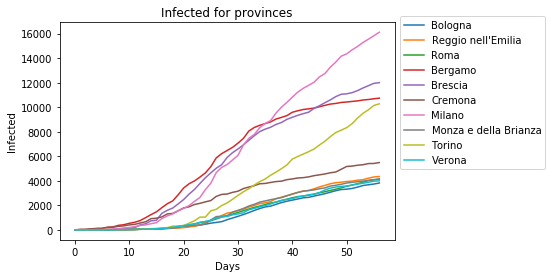

<Figure size 432x288 with 0 Axes>

In [85]:


x=len(time_line_dataset.columns[2:]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)




condition_plot(x,top_ten_list(time_line_dataset,1),['Infected','provinces'])


The graph is as we expect. In the TV news, Milano is most hit province, and we can see this trough the brown line. This could change in within few days.

Some new information could be required to have a better picture.
One of this information is the total population for each city we are taking in exam

In [45]:
population=pd.read_csv('./it.csv',encoding = "ISO-8859-1")

difference =pd.Index(time_line_dataset['denominazione_provincia'].tolist()).symmetric_difference( population['index'])
population_time_line_dataset=time_line_dataset.merge(population, left_on='denominazione_provincia', right_on='index')
del population_time_line_dataset['location']
del population_time_line_dataset['google']
del population_time_line_dataset['index']

print(population_time_line_dataset.head())


  denominazione_regione denominazione_provincia  20200224  20200225  20200226  \
0               Abruzzo                  Chieti         0         0         0   
1               Abruzzo                L'Aquila         0         0         0   
2               Abruzzo                 Pescara         0         0         0   
3               Abruzzo                  Teramo         0         0         0   
4            Basilicata                  Matera         0         0         0   

   20200227  20200228  20200229  20200301  20200302  ...  20200412  20200413  \
0         0         0         0         0         0  ...       452       465   
1         0         0         0         0         0  ...       220       220   
2         0         0         0         0         0  ...       889       930   
3         1         1         2         5         5  ...       599       598   
4         0         0         0         0         0  ...       153       155   

   20200414  20200415  20200416 

# Dataset rielaboration - Regions

Here we will make different datasets for each condition (deaths, tampons ecc...), so that will be easy afterward to analyze them
Let's strat with the structur as before

In [63]:

url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-'+str_date_formatted[0]+'.csv'
time_line_dataset_regions = pd.read_csv(url)


#adding density information from our dataset
density=pd.read_csv('./density.csv')




#removing useless/redundant columns

del time_line_dataset_regions['data'] #we already have data columns added in the reworking
del time_line_dataset_regions['stato'] #it's the italian database, we already know
del time_line_dataset_regions['codice_regione'] #it's an indicative value, it doesn't mean anything
del time_line_dataset_regions['ricoverati_con_sintomi'] #this column will be its own dataset
del time_line_dataset_regions['lat'] #We don't need this value knowing the city
del time_line_dataset_regions['long'] #We don't need this value knowing the city
del time_line_dataset_regions['note_it']
del time_line_dataset_regions['note_en']
del time_line_dataset_regions['casi_testati']
del time_line_dataset_regions['terapia_intensiva'] #this column will be its own dataset
del time_line_dataset_regions['totale_ospedalizzati'] #this column will be its own dataset
del time_line_dataset_regions['isolamento_domiciliare']#this column will be its own dataset
del time_line_dataset_regions['totale_positivi'] #this column will be its own dataset
del time_line_dataset_regions['nuovi_positivi']#this column will be its own dataset
del time_line_dataset_regions['dimessi_guariti']#this column will be its own dataset
del time_line_dataset_regions['variazione_totale_positivi']#this column will be its own dataset
del time_line_dataset_regions['deceduti'] #this column will be its own dataset
del time_line_dataset_regions['totale_casi'] #this column will be its own dataset
del time_line_dataset_regions['tamponi'] #this column will be its own dataset



#building a dataset for condition
tl_hospitalized_with_symptoms=copy.deepcopy(time_line_dataset_regions)
tl_intensive_teraphy=copy.deepcopy(time_line_dataset_regions)
tl_total_hospitalized=copy.deepcopy(time_line_dataset_regions)
tl_isolation=copy.deepcopy(time_line_dataset_regions)
tl_actual_positives=copy.deepcopy(time_line_dataset_regions)
tl_new_actual_positives=copy.deepcopy(time_line_dataset_regions)
tl_recovered=copy.deepcopy(time_line_dataset_regions)
tl_deaths=copy.deepcopy(time_line_dataset_regions)
tl_total=copy.deepcopy(time_line_dataset_regions)
tl_tampons=copy.deepcopy(time_line_dataset_regions)
tl_variance=copy.deepcopy(time_line_dataset_regions)

#This one will contain the population density now on
time_line_dataset_regions=time_line_dataset_regions.merge(density, left_on='denominazione_regione', right_on='Region')
del time_line_dataset_regions['Region']

#uploading every day for each dataset
for i in range(0,len(str_date_formatted)):
    url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-'+str_date_formatted[i]+'.csv'
    
    temp_data=pd.read_csv(url)
    tl_hospitalized_with_symptoms[str_date_formatted[i]]=temp_data['ricoverati_con_sintomi']
    tl_intensive_teraphy[str_date_formatted[i]]=temp_data['terapia_intensiva']
    tl_total_hospitalized[str_date_formatted[i]]=temp_data['totale_ospedalizzati']
    tl_isolation[str_date_formatted[i]]=temp_data['isolamento_domiciliare']
    tl_actual_positives[str_date_formatted[i]]=temp_data['totale_positivi']
    tl_new_actual_positives[str_date_formatted[i]]=temp_data['nuovi_positivi']
    tl_recovered[str_date_formatted[i]]=temp_data['dimessi_guariti']
    tl_deaths[str_date_formatted[i]]=temp_data['deceduti']
    tl_total[str_date_formatted[i]]=temp_data['totale_casi']
    tl_tampons[str_date_formatted[i]]=temp_data['tamponi']
    tl_variance[str_date_formatted[i]]=temp_data['variazione_totale_positivi']




# Dataset rielaboration - Regions Graphs

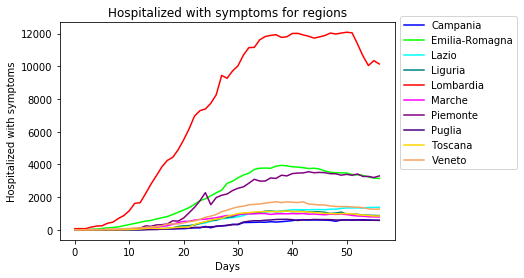

<Figure size 432x288 with 0 Axes>

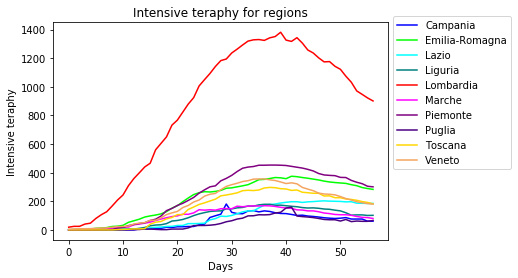

<Figure size 432x288 with 0 Axes>

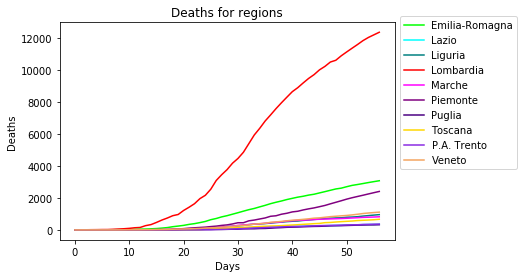

<Figure size 432x288 with 0 Axes>

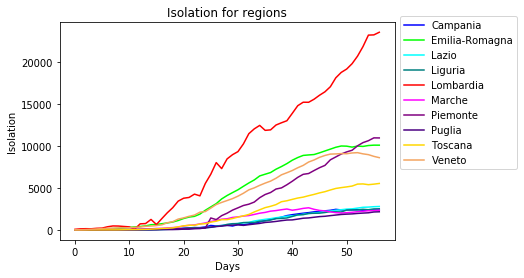

<Figure size 432x288 with 0 Axes>

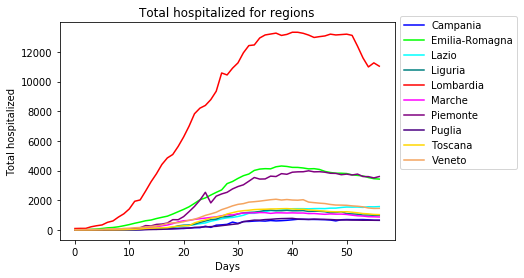

<Figure size 432x288 with 0 Axes>

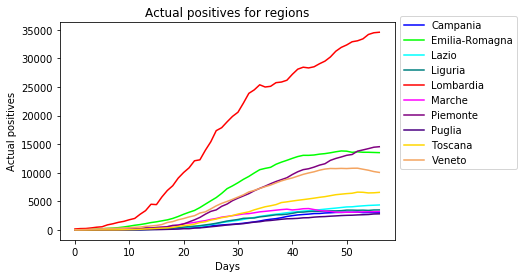

<Figure size 432x288 with 0 Axes>

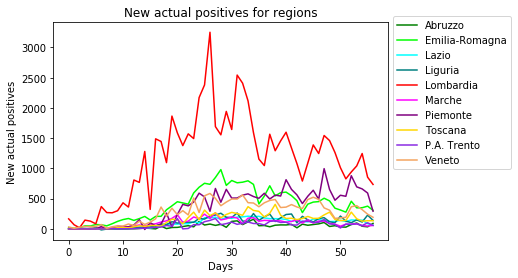

<Figure size 432x288 with 0 Axes>

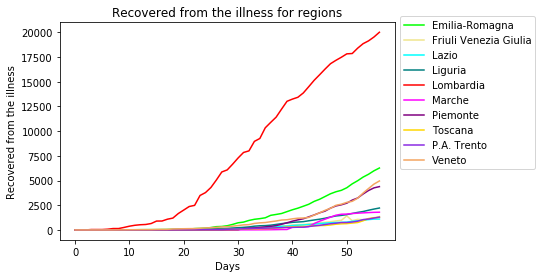

<Figure size 432x288 with 0 Axes>

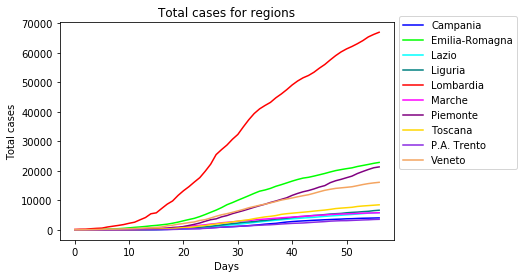

<Figure size 432x288 with 0 Axes>

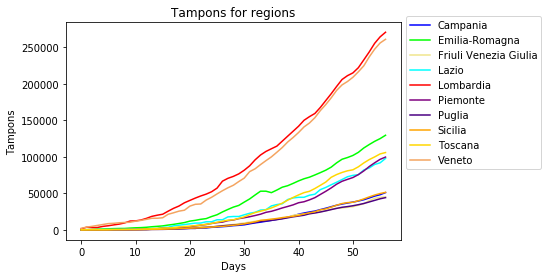

<Figure size 432x288 with 0 Axes>

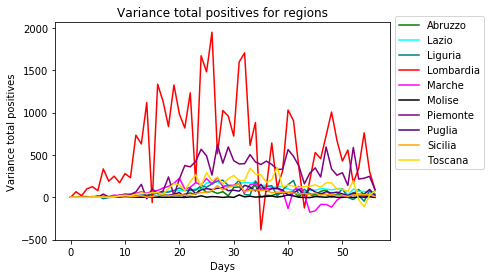

<Figure size 432x288 with 0 Axes>

In [78]:
x=len(tl_hospitalized_with_symptoms.columns[1:]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)


condition_plot(x,top_ten_list(tl_hospitalized_with_symptoms,0),['Hospitalized with symptoms','regions'])
condition_plot(x,top_ten_list(tl_intensive_teraphy,0),['Intensive teraphy','regions'])
condition_plot(x,top_ten_list(tl_deaths,0),['Deaths','regions'])
condition_plot(x,top_ten_list(tl_isolation,0),['Isolation','regions'])
condition_plot(x,top_ten_list(tl_total_hospitalized,0),['Total hospitalized','regions'])
condition_plot(x,top_ten_list(tl_actual_positives,0),['Actual positives','regions'])
condition_plot(x,top_ten_list(tl_new_actual_positives,0),['New actual positives','regions'])
condition_plot(x,top_ten_list(tl_recovered,0),['Recovered from the illness','regions'])
condition_plot(x,top_ten_list(tl_total,0),['Total cases','regions'])
condition_plot(x,top_ten_list(tl_tampons,0),['Tampons','regions'])
condition_plot(x,top_ten_list(tl_variance,0),['Variance total positives','regions'])

Lombardia is the region with the most of everything, as we should expect seen the latest news.


# Data deepening

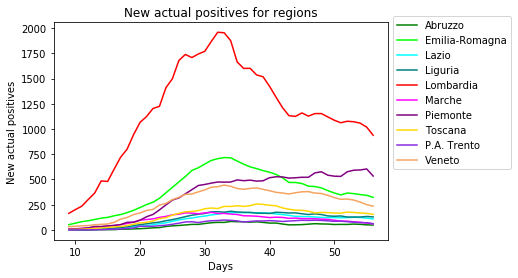

<Figure size 432x288 with 0 Axes>

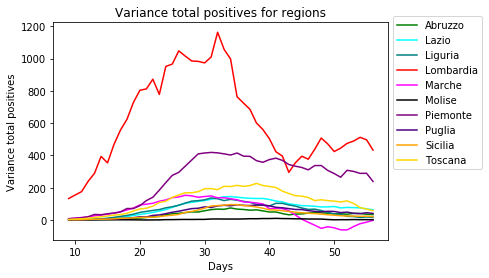

<Figure size 432x288 with 0 Axes>

In [79]:


x=len(tl_hospitalized_with_symptoms.columns[1:]) 
x=range(9,x) #Starting index is in regars of the window frame of the moving mean, in this case 10 (0 to 9)

moving_averages_NPositive=moving_mean_with_names(top_ten_list(tl_new_actual_positives,0),10)
moving_averages_variance=moving_mean_with_names(top_ten_list(tl_variance,0),10)
condition_plot(x,moving_averages_NPositive,['New actual positives','regions'])
condition_plot(x,moving_averages_variance,['Variance total positives','regions'])

With smoother lines we can have smoother conclusions about these two graphs

# Data confrontation


Let's see if comparing graphs can give us some answers visually speaking.
Of course a model it's best suited for this kind of job, but let's try out nonetheless

   denominazione_regione  Density(ab./Km^2)
6              Lombardia             422.76
3               Campania             422.25
5                  Lazio             340.47
15                Veneto             267.42
10                Puglia             205.33
4         Emilia-Romagna             198.62
12               Sicilia             192.36
9               Piemonte             171.60
13               Toscana             162.25
7                 Marche             161.55


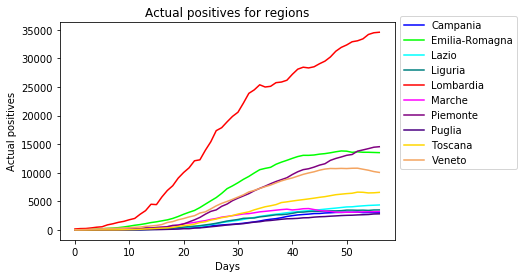

<Figure size 432x288 with 0 Axes>

In [83]:

print(time_line_dataset_regions.sort_values(by=['Density(ab./Km^2)'],ascending=False)[:10])
x=len(tl_hospitalized_with_symptoms.columns[1:]) 
x=range(0,x)
condition_plot(x,top_ten_list(tl_actual_positives,0),['Actual positives','regions'])

As a matter of fact, we can see that every single region with the most infected, is in the list of the most density population list.
It's not a perfect match, because even though Lombardy is first place in both, other regions are not, for example Campania it's second place in the population density, but it's one of the lowest on the actual positive graph.
A number of factors could be in place, like the date of the lockdown, or the behavior of the population overall, but it seems that the density population helped the diffusion of the virus as well

# Provinces considering the number of inhabitants

Since the distribution of the population for each city could give misleading information, we tried to use a sample of 30000 inhabitants to even the things up.
Since most of the italian city have around that value, with big outliers like the big cities(Milano ecc..) that value should be reasonable.
Let's then compare with the previous graph


In [94]:
population_time_line_dataset['for30k']=(population_time_line_dataset[str(yesterday).replace("-", "")]/population_time_line_dataset['population'])*30000
population_time_line_dataset.sort_values(by=['for30k'],ascending=False)[:10]

,denominazione_regione,denominazione_provincia,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,...,20200413,20200414,20200415,20200416,20200417,20200418,20200419,20200420,population,for30k
38,Lombardia,Bergamo,0,18,20,72,103,110,209,243,...,10391,10426,10472,10518,10590,10629,10689,10738,114162,2821.779576
41,Lombardia,Cremona,0,53,57,91,123,136,214,223,...,4945,5172,5202,5273,5313,5407,5417,5491,59561,2765.735968
44,Lombardia,Mantova,0,0,0,0,0,1,4,5,...,2571,2631,2655,2691,2748,2863,2905,2913,39260,2225.929699
43,Lombardia,Lodi,0,125,128,159,182,237,344,384,...,2559,2569,2587,2626,2678,2714,2724,2740,40767,2016.336743
39,Lombardia,Brescia,0,0,2,10,13,14,49,60,...,11058,11093,11187,11355,11567,11758,11946,12004,184826,1948.427169
47,Lombardia,Pavia,0,27,27,36,49,55,78,83,...,3193,3246,3316,3390,3448,3536,3582,3641,65734,1661.697143
60,Piemonte,Cuneo,0,0,0,0,0,0,0,0,...,1607,1747,1791,1814,1897,1977,2053,2075,46416,1341.132368
42,Lombardia,Lecco,0,0,0,0,0,0,2,3,...,1911,1970,1982,1986,2005,2030,2072,2080,46580,1339.630743
95,P.A. Trento,Trento,0,0,0,0,0,0,0,0,...,3126,3141,3220,3294,3376,3431,3532,3590,80425,1339.135841
48,Lombardia,Sondrio,0,1,3,3,3,3,3,3,...,796,849,859,864,866,937,956,960,21590,1333.950903


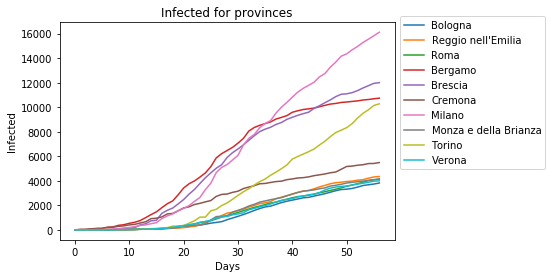

<Figure size 432x288 with 0 Axes>

In [95]:
x=len(time_line_dataset.columns[2:]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)
condition_plot(x,top_ten_list(time_line_dataset,1),['Infected','provinces'])


We can see a clear difference. Milano is top in the over all infection, but in the othe scheme is not even present. 
A couple of city are still there, like Bergamo. For Bergamo itself we can see that is first in the line, like every news article we read, so it's probably more accurate than using all the population in an uneven situation.


# Miscellanous

This code is when you downlaod the csv files on you pcs file by file.
It's no use for this notebook, avoid to compile it, it will not work.
There is also scrap code, here in case i need it again

In [72]:

'''


'''
'''
print(len(population_time_line_dataset))
print(len(time_line_dataset))
difference =pd.Index(time_line_dataset['denominazione_provincia'].tolist()).symmetric_difference( population_time_line_dataset['denominazione_provincia'])
print(difference)
'''

'''
for filename in listdir("./dati-province\\"):
   
    temp_data= pd.read_csv("./\\"+filename)

    time_line_dataset[filename[-12:-4]]=temp_data['totale_casi']
'''

'\nfor filename in listdir("./dati-province\\"):\n   \n    temp_data= pd.read_csv("./\\"+filename)\n\n    time_line_dataset[filename[-12:-4]]=temp_data[\'totale_casi\']\n'

# ARIMA model

In [37]:
###### IN THE FUTURE

model = ARIMA(???, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

ValueError: could not convert string to float: '2020-04-12'